In [78]:
import numpy as np
import cv2 as cv
import os
import json
from PIL import Image
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import time
import torch
from pathlib import Path

from lac.perception.segmentation import UnetSegmentation
from lac.perception.depth import (
    stereo_depth_from_segmentation,
    project_pixel_to_rover,
    compute_rock_coords_rover_frame,
    compute_rock_radii,
)
from lac.control.controller import ArcPlanner
from lac.utils.visualization import overlay_mask, overlay_stereo_rock_depths
from lac.utils.plotting import (
    plot_points_rover_frame,
    plot_path_rover_frame,
    plot_rocks_rover_frame,
)
from lac.utils.frames import invert_transform_mat, apply_transform
from lac.util import load_data, get_positions_from_poses
import lac.params as params

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Obstacle detection


In [79]:
segmentation = UnetSegmentation()

In [80]:
data_path = Path("../../output/AutoAgent/arc_planner_test")
data_path = Path("../../../output/RecoveryAgent/default_run")
initial_pose, lander_pose, poses, imu_data, cam_config = load_data(data_path)

(-0.5, 1279.5, 719.5, -0.5)

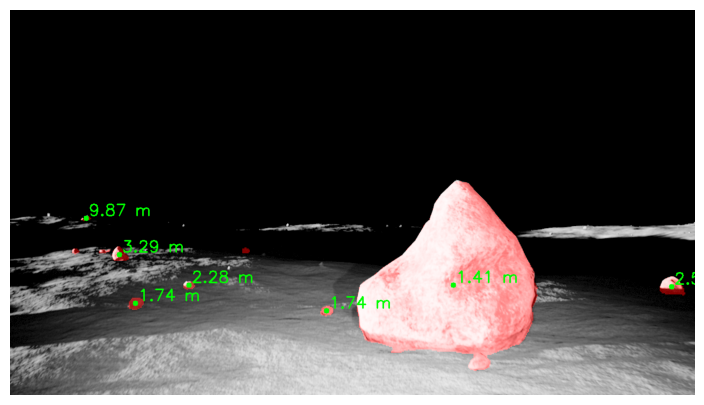

In [120]:
i = 11500

left_image = cv.imread(data_path / "FrontLeft" / f"{i:06}.png", cv.IMREAD_GRAYSCALE)
right_image = cv.imread(data_path / "FrontRight" / f"{i:06}.png", cv.IMREAD_GRAYSCALE)

left_masks, left_labels = segmentation.segment_rocks(left_image)
right_masks, right_labels = segmentation.segment_rocks(right_image)
left_seg_full_mask = np.clip(left_labels, 0, 1).astype(np.uint8)
right_seg_full_mask = np.clip(right_labels, 0, 1).astype(np.uint8)

results = stereo_depth_from_segmentation(left_masks, right_masks, params.STEREO_BASELINE, params.FL_X)
left_overlay = overlay_mask(np.array(left_image), left_seg_full_mask)
left_overlay = overlay_stereo_rock_depths(left_overlay, results)
fig = plt.figure(figsize=(10, 5), dpi=100)
plt.imshow(left_overlay)
plt.axis("off")

In [121]:
# TODO: use compute_rock_points and compute_rock_radii

In [122]:
x, _, w, _ = cv.boundingRect(results[0]["left_mask"].astype(np.uint8))
width_x = w * results[0]["depth"] / params.FL_X
print(f"Width: {width_x} m")

Width: 0.215999999856 m


In [123]:
lander_local = apply_transform(invert_transform_mat(poses[i]), params.LANDER_GLOBAL)
lander_local

array([[-1.30716902, -9.22896513, -1.43005745],
       [-4.29783504, -9.36359805, -1.23565909],
       [-4.43169658, -6.36662998, -1.21942745],
       [-1.44103056, -6.23199706, -1.4138258 ]])

In [124]:
rock_points_rover_frame = []
rock_data = compute_rock_radii(results)

for rock in results:
    rock_points_rover_frame.append(
        project_pixel_to_rover(rock["left_centroid"], rock["depth"], "FrontLeft", cam_config)
    )

rock_points_rover_frame = np.array(rock_points_rover_frame)
# print(rock_points_rover_frame)
fig = go.Figure()
fig.add_trace(go.Scatter(x=lander_local[:, 1], y=lander_local[:, 0], fill="toself", name="lander"))
fig = plot_rocks_rover_frame(rock_points_rover_frame, rock_data, fig=fig, color="red")
fig.show()

In [125]:
rock_data

[0.107999999928,
 0.05759999998720001,
 0.06703448274706303,
 0.02741538461116687,
 0.02858823529075433,
 0.02287058823260346,
 0.26074285711802453]

## Arc path planning


In [126]:
planner = ArcPlanner(15)


arcs = planner.np_candidate_arcs

[(0.2, -1.0), (0.2, -0.8571428571428572), (0.2, -0.7142857142857143), (0.2, -0.5714285714285714), (0.2, -0.4285714285714286), (0.2, -0.2857142857142858), (0.2, -0.1428571428571429), (0.2, 0.0), (0.2, 0.1428571428571428), (0.2, 0.2857142857142856), (0.2, 0.4285714285714284), (0.2, 0.5714285714285714), (0.2, 0.7142857142857142), (0.2, 0.857142857142857), (0.2, 1.0)]


In [127]:
print(rock_points_rover_frame)
test_rock_points_rover_frame = np.array([[0.5, 0.5], [0.4, -0.4], [0.2, 0.3]])

[[10.15136402  5.4594     -0.1822    ]
 [ 3.57045467  1.6506     -0.2182    ]
 [ 2.83293897 -1.58368965 -0.30751724]
 [ 2.55800708  0.84364615 -0.25281538]
 [ 2.02200542  0.85478824 -0.22730588]
 [ 2.02200542  0.17438824 -0.25398824]
 [ 1.69019486 -0.20905714 -0.1066    ]]


In [128]:
test_rock_data = [0.07, 0.06, 0.05]

In [ ]:
# print(f"candidate arcs shape: {planner.np_candidate_arcs.shape}")
waypoint = np.array([-7.5, -7.5]) # would prefer a way to automate this
current_pose = poses[i]

test_rock_points_rover_frame = np.array([[]])
test_rock_data = []
control, best_arc, waypoint_local = planner.plan_arc(waypoint, current_pose, rock_points_rover_frame, rock_data)
# (v,w), waypoint_local = planner.plan_arc(waypoint, current_pose, test_rock_points_rover_frame, test_rock_data)
# print(waypoint_local)
fig = plot_rocks_rover_frame(rock_points_rover_frame, rock_data, color="red")
print(f"waypoint_local{waypoint_local}")
# fig = go.Figure()
for arc in arcs:
    fig = plot_path_rover_frame(arc, fig=fig)
fig = plot_path_rover_frame(best_arc, color="green", fig=fig)

fig.show()
print(control)

len sorted indices 15
len self.vw 15
i: 7
waypoint_local[ 4.2725784   0.03120493 -1.77015923  1.        ]


(0.2, 0.0)


In [76]:
import pickle

with open('../../../output/RecoveryAgent/default_run/path_planner_stats.pkl', 'rb') as f:
    data = pickle.load(f)
print(data)

{'collision detections': [], 'planner_failure': [(11752, array([[-7.39481052e-01, -6.68335187e-01,  8.05968446e-02,
        -4.52121735e+00],
       [ 6.64160101e-01, -7.43858446e-01, -7.46054491e-02,
        -7.73342562e+00],
       [ 1.09814090e-01, -1.64010748e-03,  9.93950791e-01,
         1.49270737e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]]))], 'time taken': 11752, 'success': False}


# Arc overlay visualization


In [77]:
from lac.utils.camera import Camera
from lac.utils.frames import get_cam_pose_rover, CAMERA_TO_OPENCV_PASSIVE
from lac.utils.plotting import plot_poses

In [ ]:
def rover_pose_to_cam_pose(rover_pose, cam_name="FrontLeft"):
    camera_pose = get_cam_pose_rover(cam_name)
    camera_pose[:3, :3] = CAMERA_TO_OPENCV_PASSIVE
    return rover_pose @ camera_pose

In [ ]:
# data_path = Path("../../output/AutoAgent/arc_planner_test")
data_path = Path("../../output/NavAgent/map1_preset4_eval")
initial_pose, lander_pose, poses, imu_data, cam_config = load_data(data_path)

In [ ]:
cam_poses = []
for pose in poses:
    cam_poses.append(rover_pose_to_cam_pose(pose))

In [ ]:
plot_poses(cam_poses[::100])

In [ ]:
cam = Camera(cam_poses[0])

# TODO: define arc points
arc_points = None

uv, depths = cam.project_world_points_to_uv(arc_points)

In [ ]:
plt.scatter(uv[:, 0], uv[:, 1], cmap="plasma")
# Set x and y limits
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.gca().invert_yaxis()
plt.show()